In [172]:
import numpy as np
import pandas as pd
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
import uuid

def pd_display(df, **kwargs):
    text = df.to_string(**kwargs)
    display(Markdown(f"```\n{text}\n```"))

def run_simulation(T=200, arrival_rate=0.8, service_delay_A=2, service_delay_B=2,
                   service_delay_C=2, rework_prob=0.2, seed=42):
    np.random.seed(seed)

    # First pass to determine max number of entities
    estimated_arrivals = int(arrival_rate * T * 1.5)  # generous upper bound
    queues = ['A', 'B', 'C', 'System']
    presence = {
        q: np.zeros((estimated_arrivals, T), dtype=bool)
        for q in queues
    }
    arrival_index = {
        q: np.zeros(T, dtype=int)
        for q in queues
    }

    #for each entity, records the time index of arrivals (supports reentrancy)
    visit_index = {q: [[] for _ in range(estimated_arrivals)] for q in queues}

    entity_index = {}
    queue_A, queue_B, queue_C = deque(), deque(), deque(),

    entity_counter = 0

    def process_queue(queue, service_delay, current_time, next_queue):
        new_queue = deque()
        for item in queue:
            if current_time - item['start_time'] >= service_delay:
                if next_queue is not None:
                    item['start_time'] = current_time
                    next_queue.append(item)
            else:
                new_queue.append(item)
        return new_queue

    def record_presence(queue_id, item, t, entity_index, presence, arrival_index):
        row = entity_index[item['id']]
        presence[queue_id][row, t] = True
        if t==0 or not presence[queue_id][row, t-1]:
            arrival_index[queue_id][t] += 1
            # add the time index of arrival for the item to visit_index
            visit_index[queue_id][row].append(t)


    for t in range(T):
        if np.random.rand() < arrival_rate:
            entity_id = str(uuid.uuid4())
            entity_index[entity_id] = entity_counter
            queue_A.append({'id': entity_id, 'start_time': t})
            entity_counter += 1

        new_C = deque()
        for item in queue_C:
            if t - item['start_time'] >= service_delay_C:
                if np.random.rand() < rework_prob:
                    item['start_time'] = t
                    queue_A.append(item)
                # Else exits the system
            else:
                new_C.append(item)
        queue_C = new_C

        queue_B = process_queue(queue_B, service_delay_B, t, queue_C)
        queue_A = process_queue(queue_A, service_delay_A, t, queue_B)

        for queue_id, queue in zip(['A', 'B', 'C'], [queue_A, queue_B, queue_C]):
            for item in queue:
                record_presence(queue_id, item, t, entity_index, presence, arrival_index)
                record_presence("System", item, t, entity_index, presence, arrival_index)

    return presence, arrival_index, entity_index, visit_index

def get_entry_exit_times(presence, entity_index, queue_name):
    arrivals = []
    departures = []
    mat = presence[queue_name]
    for i in range(mat.shape[0]):
        times = np.where(mat[i])[0]
        if times.size > 0:
            arrivals.append(times[0])
            departures.append(times[-1] + 1)
    return arrivals, departures



def compute_cumulative_arrival_rate(arrival_index, presence, t0, t1):
    """Cumulative arrival rate over [t0, t1): arrivals + number in system at t0, divided by window length."""
    in_system_at_t0 = np.sum(presence[:, t0 - 1]) if t0 > 0 else 0
    arrivals_during_window = np.sum(arrival_index[t0:t1])
    total_entities = in_system_at_t0 + arrivals_during_window
    return total_entities / (t1 - t0) if t1 > t0 else 0.0

def compute_average_number_in_queue(presence, t0, t1):
    """Average number of entities present during [t0, t1)."""
    window = presence[:, t0:t1]                   # submatrix over the window
    count_per_time = np.sum(window, axis=0)       # sum across rows for each column (time step)
    return np.mean(count_per_time)

def compute_average_residence_time(visit_index, presence,  t0, t1):
    """Average time in system for entities present during [t0, t1)."""
    window = presence[:, t0:t1]                  # submatrix over the window
    total_time = np.sum(window)    # sum across columns for each row (entity)
    total_visits = 0
    for row_visits in visit_index:
        total_visits += sum(t0 <= t < t1 for t in row_visits)

    return total_time / total_visits if total_visits > 0 else 0.0

def compute_operator_flow_metrics(presence, arrival_index, visit_index, t0, t1):
    return {
        'lambda': compute_cumulative_arrival_rate(arrival_index, presence, t0, t1),
        'L': compute_average_number_in_queue(presence, t0, t1),
        'W': compute_average_residence_time(visit_index, presence,  t0, t1),
        'window': (t0, t1)
    }



def compute_entity_flow_metrics(presence, arrival_index, visit_index, t0, t1):
    # Step 1: Identify all entities present during [t0, t1)
    active_entities = np.any(presence[:, t0:t1], axis=1)
    entity_rows = presence[active_entities]

    # Step 2: Find min and max time index with presence among those entities
    time_presence = np.any(entity_rows, axis=0)
    t_indices = np.where(time_presence)[0]
    if len(t_indices) == 0:
        return {'lambda': 0, 'L': 0, 'W': 0, 'span': (t0, t1)}

    t_prime_0 = t_indices[0]
    t_prime_1 = t_indices[-1] + 1

    # Step 3: Compute the operator flow metrics for that window.
    return compute_operator_flow_metrics(presence, arrival_index, visit_index, t_prime_0, t_prime_1)


# -----------------------------------
# Analytics
# -----------------------------------
def plot_cumulative_flow(queue_name, presence, entity_index, T=200):
    entry_times, exit_times = get_entry_exit_times(presence, entity_index, queue_name)
    arrivals = np.zeros(T)
    departures = np.zeros(T)
    for t in entry_times:
        if t < T:
            arrivals[t] += 1
    for t in exit_times:
        if t < T:
            departures[t] += 1
    cumulative_arrivals = np.cumsum(arrivals)
    cumulative_departures = np.cumsum(departures)
    plt.figure(figsize=(10, 5))
    plt.plot(range(T), cumulative_arrivals, label='Cumulative Arrivals')
    plt.plot(range(T), cumulative_departures, label='Cumulative Departures')
    plt.title(f"Cumulative Flow Diagram (Queue {queue_name})")
    plt.xlabel("Time")
    plt.ylabel("Cumulative Count")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return pd.DataFrame({
        "Time": np.arange(T),
        "Cumulative Arrivals": cumulative_arrivals,
        "Cumulative Departures": cumulative_departures
    })

def plot_l_vs_lambda_w(presence, arrival_index, visit_index):
    T = presence.shape[1]
    data = []

    for t in range(1, T):
        lam = compute_cumulative_arrival_rate(arrival_index, presence, 0, t)
        L = compute_average_number_in_queue(presence, 0, t)
        W = compute_average_residence_time(visit_index, presence, 0, t)
        data.append({"window_end": t, "lambda": lam, "W": W, "L": L, "lambda*W": lam * W})

    df = pd.DataFrame(data)

    plt.figure(figsize=(8, 6))
    plt.plot(df["L"], df["lambda*W"], 'o', label="Observed (L vs λW)")


    plt.plot([df["L"].min(), df["L"].max()],
             [df["L"].min(), df["L"].max()],
             'r--', label="x = y")
    plt.xlabel("Average Number in Queue (L)")
    plt.ylabel("Cumulative Arrival Rate × Average Residence Time (λ × W)")
    plt.title("L vs λW over intervals [0, t)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return df

def estimate_limits(df, tail_frac=0.2):
    tail = df.tail(int(len(df) * tail_frac))
    return {
        "lambda_limit": tail["lambda"].mean(),
        "W_limit": tail["W"].mean(),
        "L_limit": tail["L"].mean(),
        "L_estimated": tail["lambda"].mean() * tail["W"].mean()
    }

def plot_limit_curves(presence, arrival_index, visit_index):
    T = presence.shape[1]
    data = []

    for t in range(1, T):
        lam = compute_cumulative_arrival_rate(arrival_index, presence, 0, t)
        L = compute_average_number_in_queue(presence, 0, t)
        W = compute_average_residence_time(visit_index, presence, 0, t)
        data.append({"window_end": t, "lambda": lam, "W": W, "L": L})

    df = pd.DataFrame(data)
    limits = estimate_limits(df)

    plt.figure(figsize=(10, 7))
    plt.plot(df["window_end"], df["L"], label="Average Number in Queue (L)")
    plt.plot(df["window_end"], df["lambda"], label="Cumulative Arrival Rate (λ)")
    plt.plot(df["window_end"], df["W"], label="Average Residence Time (W)")

    plt.axhline(limits["lambda_limit"], color='orange', linestyle=':', label='λ limit')
    plt.axhline(limits["W_limit"], color='green', linestyle=':', label='W limit')
    plt.axhline(limits["L_limit"], color='blue', linestyle=':', label='L limit')

    plt.xlabel("Window End Time (Window Size = t - 0)")
    plt.ylabel("Metric Value")
    plt.title("Convergence of L, λ, and W over Increasing Window Sizes")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return df

def detect_stability_by_tail_convergence(df, tail_frac=0.2, epsilon=0.005):
    deltas = []
    window_ends = df["window_end"].values

    for i in range(1, len(df)):
        tail_size = max(1, int(tail_frac * i))
        tail = df.iloc[i - tail_size + 1:i + 1]
        lam_tail = tail["lambda"].mean()
        W_tail = tail["W"].mean()
        L_tail = tail["L"].mean()
        L_estimated = lam_tail * W_tail
        delta = abs(L_tail - L_estimated)
        deltas.append({
            "window_end": window_ends[i],
            "delta": delta,
            "L_tail": L_tail,
            "L_estimated": L_estimated,
            "lambda_tail": lam_tail,
            "W_tail": W_tail,
            "stable": delta < epsilon
        })

    delta_df = pd.DataFrame(deltas)

    plt.figure(figsize=(10, 6))
    plt.plot(delta_df["window_end"], delta_df["delta"], label="|L - λ×W|")
    plt.axhline(epsilon, color='red', linestyle='--', label=f'ε = {epsilon}')
    plt.xlabel("Window End Time")
    plt.ylabel("Delta: |L - λ×W|")
    plt.title("Convergence of L = λ × W (Tail-Averaged)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return delta_df


def plot_residence_time_convergence(presence, arrival_index, visit_index):
    T = presence.shape[1]
    data = []

    for t in range(1, T):
        op_metrics = compute_operator_flow_metrics(presence, arrival_index, visit_index, 0, t)
        ent_metrics = compute_entity_flow_metrics(presence, arrival_index, visit_index, 0, t)
        data.append({
            'window_end': t,
            'W_operator': op_metrics['W'],
            'W_entity': ent_metrics['W']
        })

    df = pd.DataFrame(data)

    plt.figure(figsize=(10, 6))
    plt.plot(df["window_end"], df["W_operator"], label="Operator Perspective W", linewidth=2)
    plt.plot(df["window_end"], df["W_entity"], label="Entity Perspective W", linewidth=2, linestyle="--")
    plt.xlabel("Window End Time")
    plt.ylabel("Average Residence Time (W)")
    plt.title("Convergence of Residence Time from Operator and Entity Perspectives")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return df

def plot_tail_convergence_of_residence_time(presence, arrival_index, visit_index, tail_frac=0.2):
    T = presence.shape[1]
    data = []

    for t in range(1, T):
        op_metrics = compute_operator_flow_metrics(presence, arrival_index, visit_index,  0, t)
        ent_metrics = compute_entity_flow_metrics(presence, arrival_index, visit_index, 0, t)
        data.append({
            'window_end': t,
            'W_operator': op_metrics['W'],
            'W_entity': ent_metrics['W']
        })

    df = pd.DataFrame(data)

    # Tail convergence analysis
    tail_deltas = []
    for i in range(1, len(df)):
        tail_size = max(1, int(tail_frac * i))
        tail = df.iloc[i - tail_size + 1:i + 1]
        W_op_tail = tail["W_operator"].mean()
        W_ent_tail = tail["W_entity"].mean()
        delta = abs(W_op_tail - W_ent_tail)
        tail_deltas.append({
            "window_end": df["window_end"].iloc[i],
            "W_operator_tail": W_op_tail,
            "W_entity_tail": W_ent_tail,
            "delta": delta
        })

    delta_df = pd.DataFrame(tail_deltas)

    plt.figure(figsize=(10, 6))
    plt.plot(delta_df["window_end"], delta_df["W_operator_tail"], label="W_operator (tail avg)", linewidth=2)
    plt.plot(delta_df["window_end"], delta_df["W_entity_tail"], label="W_entity (tail avg)", linewidth=2, linestyle="--")
    plt.xlabel("Window End Time")
    plt.ylabel("Tail-Averaged Residence Time (W)")
    plt.title(f"Tail Convergence of Residence Time (Tail = {int(tail_frac * 100)}%)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return delta_df

def detect_tail_convergence(delta_df, tail_frac=0.2, epsilon=0.05):
    """
    Annotates chart with the first window_end where convergence occurs.
    """
    delta_df = delta_df.copy()
    delta_df["tail_size_days"] = (tail_frac * delta_df["window_end"]).astype(int)
    delta_df["converged"] = delta_df["delta"] < epsilon

    tail_size_annotation = int(tail_frac * delta_df["window_end"].max())

    # Find first convergence point
    first_converged = delta_df[delta_df["converged"]].head(1)
    convergence_point = first_converged["window_end"].values[0] if not first_converged.empty else None

    plt.figure(figsize=(10, 6))
    plt.plot(delta_df["window_end"], delta_df["delta"],
             label=f"|W_op - W_ent| (tail avg, {tail_size_annotation} days)", linewidth=2)
    plt.axhline(epsilon, color='red', linestyle='--', label=f'ε = {epsilon}')

    if convergence_point:
        plt.axvline(convergence_point, color='green', linestyle=':', linewidth=1.5, label=f"Converged at t = {convergence_point}")
        plt.text(convergence_point + 1, epsilon + 0.02,
                 f"t = {convergence_point}", color='green', fontsize=10)

    plt.xlabel("Window End Time")
    plt.ylabel("Tail Delta")
    plt.title("Tail Convergence of Residence Time (Entity vs Operator Perspective)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return delta_df[["window_end", "tail_size_days", "delta", "converged"]]


def compute_lambda_L_phase_trajectory(presence, arrival_index, visit_index, window_size=20):
    T = presence.shape[1]

    phase_points = []
    for t in range(1, T):  # start from 2 to avoid divide-by-zero
        metrics = compute_operator_flow_metrics(presence, arrival_index, visit_index, 0, t)
        phase_points.append((metrics['lambda'], metrics['L']))
    return phase_points

def plot_lambda_L_phase_trajectory(presence, arrival_index, visit_index,  T, window_size=20,):
    trajectory = compute_lambda_L_phase_trajectory(presence, arrival_index, visit_index,window_size)
    avg_W = compute_average_residence_time(visit_index, presence, t0=0, t1=T)

    lambdas, Ls = zip(*trajectory)

    lambda_vals = np.linspace(min(lambdas), max(lambdas), 200)
    L_ideal = lambda_vals * avg_W

    plt.figure(figsize=(8, 6))
    plt.plot(lambdas, Ls, marker='o', markersize=2, linewidth=0.7)
    plt.plot(lambda_vals, L_ideal, 'r--', label=f"Little's Law (W̄ = {avg_W:.2f})")

    plt.xlabel("λ (Arrival Rate)")
    plt.ylabel("L (Average Number in System)")
    plt.title("λ vs L Phase Space Trajectory")
    plt.grid(True)
    plt.show()


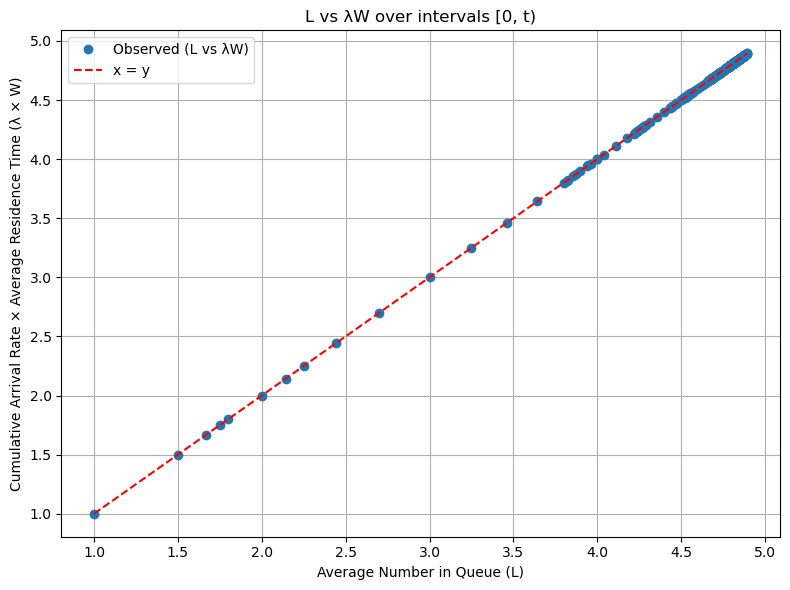

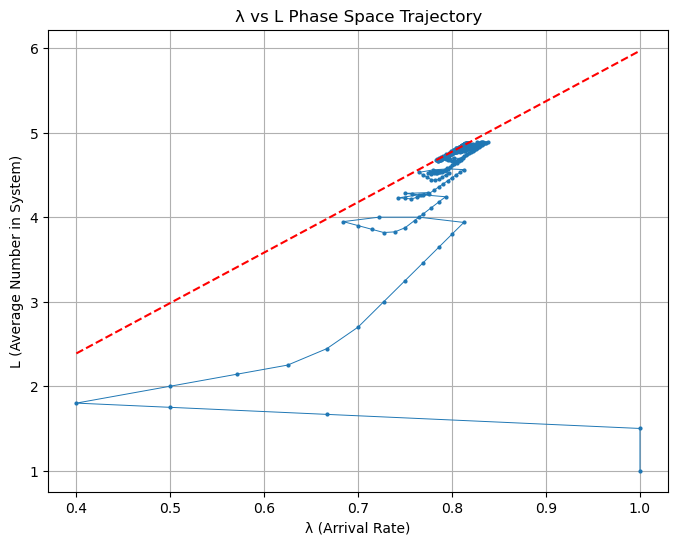

In [179]:
queue = "System"
T = 600
presence, arrival_index, entity_index, visit_index = run_simulation(T, seed=81, rework_prob=0)



df_stats = plot_l_vs_lambda_w(presence[queue], arrival_index[queue], visit_index[queue])




plot_lambda_L_phase_trajectory(presence[queue], arrival_index[queue], visit_index[queue], T)




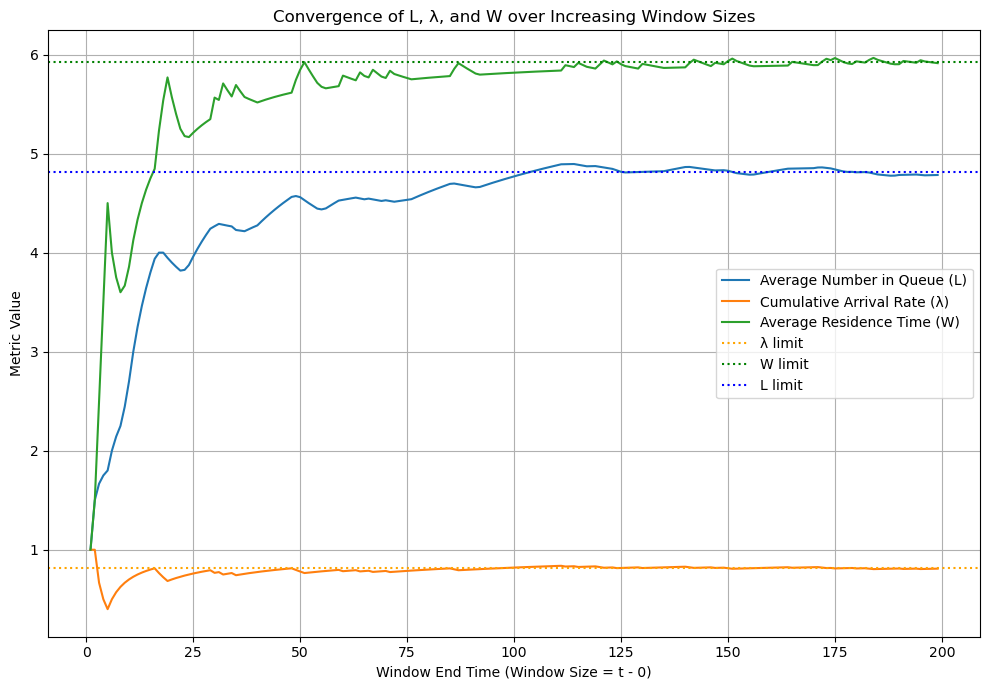

-7.795652015563093e-05


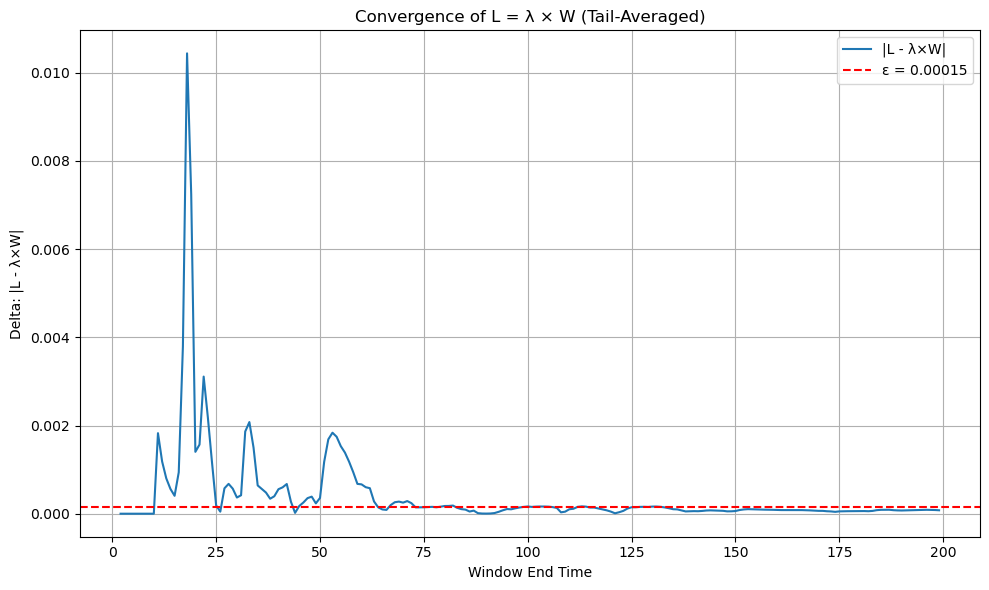

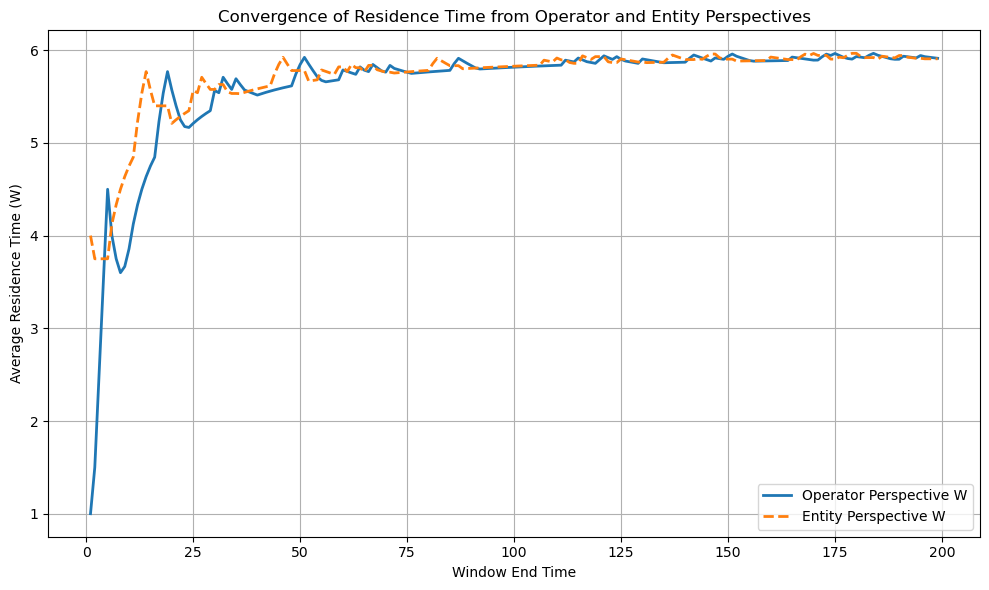

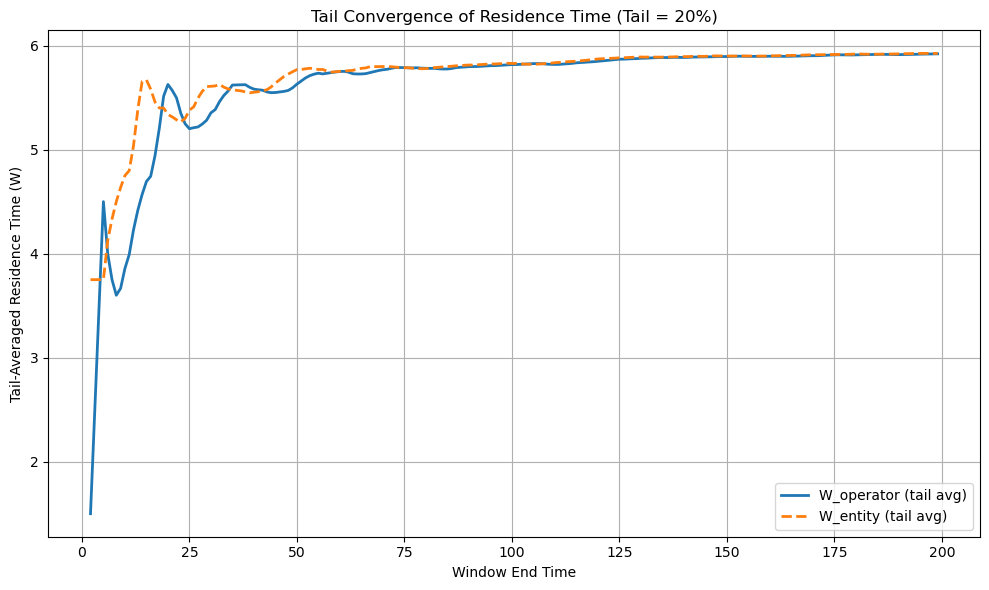

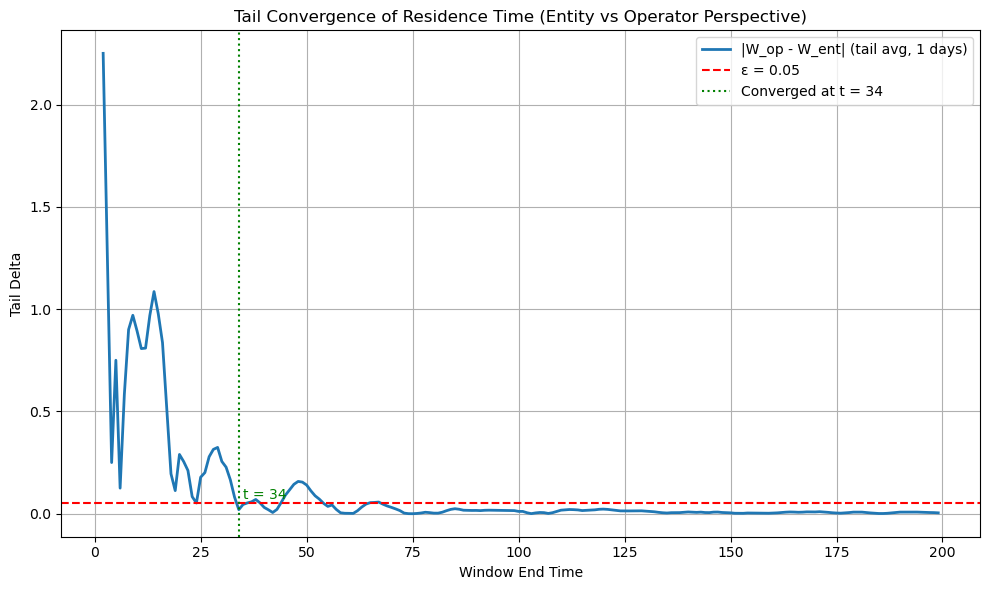

,window_end,tail_size_days,delta,converged
0,2,0,2.25,False
1,3,0,1.25,False
2,4,0,0.25,False
3,5,0,0.75,False
4,6,0,0.125,False
...,...,...,...,...
193,195,1,0.007076840337209234,True
194,196,1,0.006306348548357654,True
195,197,1,0.005756100708886436,True
196,198,1,0.005355687968730649,True


In [171]:
df_limits = plot_limit_curves(presence[queue], arrival_index[queue], visit_index[queue])

limits = estimate_limits(df_stats)
print(limits['L_limit'] - limits['L_estimated'])

tail_convergence = detect_stability_by_tail_convergence(df_stats, tail_frac=0.2, epsilon=0.00015)

plot_residence_time_convergence(presence[queue], arrival_index[queue], visit_index[queue])

tail_convergence_df = plot_tail_convergence_of_residence_time(presence[queue], arrival_index[queue], visit_index[queue], tail_frac=0.2)
detect_tail_convergence(tail_convergence_df, tail_frac=0.01)




In [127]:
arr = compute_cumulative_arrival_rate(arrival_index[queue], presence[queue], 0,7)
w = compute_average_residence_time(visit_index[queue],presence[queue], 0,7)
l = compute_average_number_in_queue(presence[queue], 0,7)
delta = l - arr*w
